In [3]:
import xgboost
import shap
import numpy as np
# Load the dataset
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)
# Convert y to binary high-income and low-income
y_binary = np.array([1 if income == True else 0 for income in y])
# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

SHAP values for the current instance:


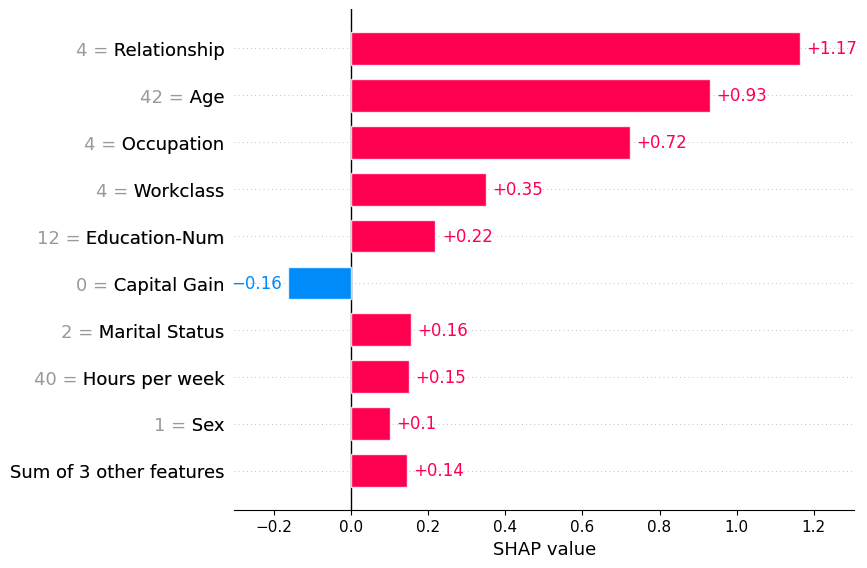

In [142]:
current_instance = X.iloc[100]  # Example: first instance
current_shap_values = shap_values[100]
print("SHAP values for the current instance:")
shap.plots.bar(current_shap_values)

In [143]:
current_shap_values = shap_values[100]


In [70]:
current_shap_values.data

array([42.,  4., 12.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.])

Initial prediction: 1, Initial probability: 0.6770620346069336
Counterfactual prediction: 0, Counterfactual probability: 0.053557388484478
The prediction is successfully flipped.


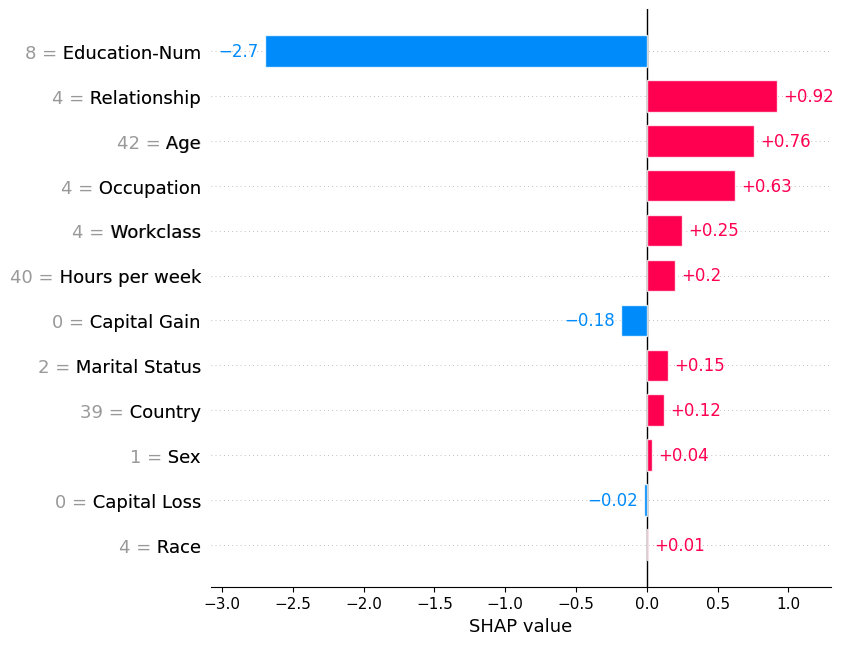

In [158]:
import xgboost
import shap
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load the dataset
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)

# Convert y to binary high-income and low-income
y_binary = np.array([1 if income == True else 0 for income in y])

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
current_instance = X.iloc[100]  # Example: first instance
current_shap_values = shap_values[100]

# Predict the initial outcome
initial_prediction = model.predict(current_instance.values.reshape(1, -1))[0]
initial_probability = model.predict_proba(current_instance.values.reshape(1, -1))[0, 1]
print(f"Initial prediction: {initial_prediction}, Initial probability: {initial_probability}")


# Define the objective function for optimization
def objective_function(x):
    # Create a DataFrame with the current instance modified by x
    new_instance = pd.DataFrame([current_instance.values], columns=X.columns)
    new_instance.iloc[0] = x
    
    # Predict the probability of the positive class (high income)
    pred = model.predict_proba(new_instance)[0, 1]
    
    # We want to flip the outcome, so we minimize the distance to the decision boundary (0.5)
    return abs(pred - 0.5)

# Constraints to keep the modified instance similar to the original instance
constraints = [{'type': 'eq', 'fun': lambda x: np.linalg.norm(x - current_instance.values) - 0.1}]

# Bounds for each feature to ensure they stay within valid ranges
bounds = [(X[col].min(), X[col].max()) for col in X.columns]

# Optimize to find the counterfactual instance
result = minimize(objective_function, current_instance.values, bounds=bounds, constraints=constraints, method='SLSQP')

# The counterfactual instance

counterfactual_instance = [[42.,  4., 8.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           [42.,  4., 9.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           [42.,  4., 10.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.],
                           [42.,  4., 11.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.]
                           ]

counterfactual_instance_df = pd.DataFrame(counterfactual_instance, columns=X.columns)

# Predict the outcome for the counterfactual instance
counterfactual_prediction = model.predict(counterfactual_instance_df)[0]
counterfactual_probability = model.predict_proba(counterfactual_instance_df)[0, 1]
print(f"Counterfactual prediction: {counterfactual_prediction}, Counterfactual probability: {counterfactual_probability}")

# Ensure the prediction is flipped
if counterfactual_prediction != initial_prediction:
    print("The prediction is successfully flipped.")
else:
    print("The prediction is not flipped. Adjust constraints or bounds and try again.")

# Compute SHAP values for the counterfactual instance
counterfactual_shap_values = explainer(counterfactual_instance_df)
shap.plots.bar(counterfactual_shap_values[0],max_display=12)


.values =
array([ 1.21671578,  0.27819034, -0.54957987,  0.1520882 ,  0.64691219,
        1.07653272,  0.05423153,  0.03615856, -0.17669509, -0.02346667,
        0.23313781,  0.1313953 ])

.base_values =
-3.034144449280776

.data =
array([42.,  4.,  9.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.])

In [72]:
counterfactual_instance_df

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,25.0,4.0,12.0,2.0,1.0,4.0,4.0,1.0,0.0,0.0,40.0,39.0


In [139]:
counterfactual_shap_values = shap_values[1135]

In [156]:
counterfactual_shap_values

.values =
array([[ 0.75700148,  0.24825553, -2.69913262,  0.15112477,  0.62528843,
         0.91859919,  0.00575521,  0.03659664, -0.17917322, -0.02066406,
         0.19631799,  0.12221741]])

.base_values =
array([-3.03414445])

.data =
array([[42.,  4.,  8.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.]])

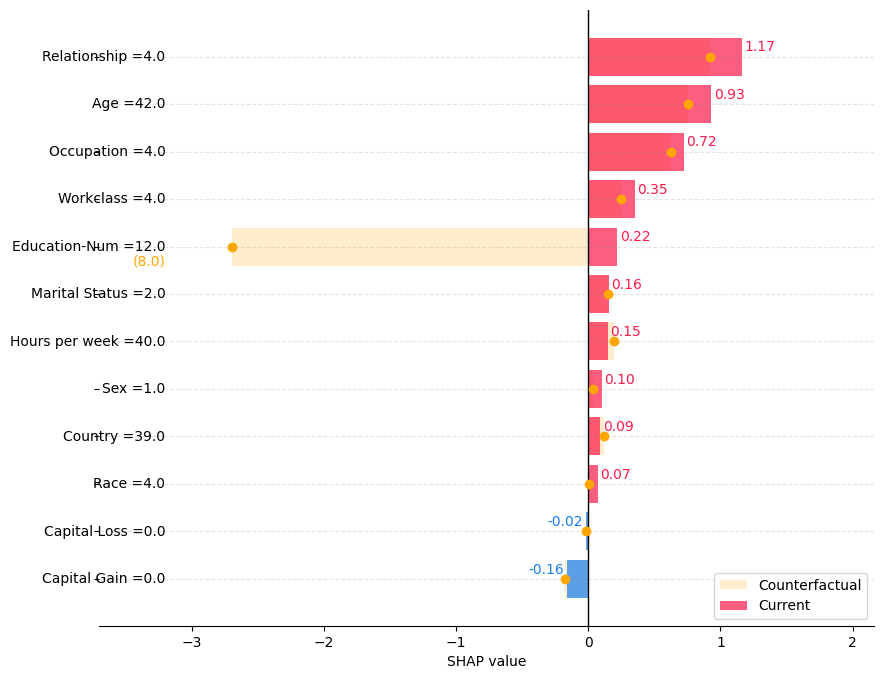

In [155]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and general_case_shap_values are already defined
# And X is the dataset used for feature columns

# Convert SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values,
    'current_feature_value': current_shap_values.data,
    'counterfactual_value': counterfactual_shap_values.values,
    'counterfactual_feature_value': counterfactual_shap_values.data,
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]

# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot general SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['counterfactual_value'], color='orange', alpha=0.2, label='Counterfactual')

# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, alpha=0.7, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add annotations comparing to the general case
for idx, row in shap_df.iterrows():
    plt.scatter([row['counterfactual_value']], [idx], color='orange', edgecolors='orange', zorder=5)
    # plt.text(row['general_value'], idx + 0.4, f"{row['general_value']:.2f}", color='orange')

# Add feature values next to the y-axis and on the bars
for idx, row in shap_df.iterrows():
    if row['current_value'] >= 0:
        plt.text(row['current_value'] + 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
    else:
        plt.text(row['current_value'] - 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

# plt.title('SHAP Values for Current Instance vs contercounterfactual example')
plt.xlabel('SHAP value')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['counterfactual_value'].min())
max_value = max(shap_df['current_value'].max(), shap_df['counterfactual_value'].max())
# Set y-tick labels with custom formatting
for i, row in shap_df.iterrows():
    ax.text(min_value-0.5, i, f"{row['feature']} ={row['current_feature_value']:.1f}", va='center', ha='right', color='black', fontsize=10)
    if row['counterfactual_feature_value'] != row['current_feature_value']:
        ax.text(min_value -0.5, i + 0.3, f"({row['counterfactual_feature_value']:.1f})", va='center', ha='right', color='orange', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value - 1,right=max_value+1)

# Show the legend
plt.legend()

plt.show()


In [117]:
import xgboost
import shap
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean

# Load the dataset
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)

# Convert y to binary high-income and low-income
y_binary = np.array([1 if income == True else 0 for income in y])

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
current_instance = X.iloc[100]  # Example: first instance
current_shap_values = shap_values[100]

# Predict the outcome for the current instance
current_prediction = model.predict(current_instance.values.reshape(1, -1))[0]
print("current_prediction",current_prediction)

# Predict the outcomes for all instances in the dataset
predictions = model.predict(X)

# Filter out instances with the same prediction as the current instance
different_outcome_indices = np.where((predictions != current_prediction) & (predictions == y_binary))[0]

# Check if there are any instances with a different predicted outcome
if len(different_outcome_indices) == 0:
    print("No instances with a different predicted outcome found.")
else:
    different_outcome_instances = X.iloc[different_outcome_indices]
    print("different_outcome_instances",len(different_outcome_instances))

    # Compute the Euclidean distance between the current instance and all instances with a different outcome
    distances = different_outcome_instances.apply(lambda row: euclidean(row, current_instance), axis=1)
    # Find the index of the instance with the minimum distance
    closest_index_within_filtered = distances.idxmin()
    closest_indices_within_filtered = distances.nsmallest(10).index
    print(f"Closest indices within filtered: {closest_indices_within_filtered}")
    # Map these indices back to the original DataFrame
    # Retrieve the original indices of the 10 closest instances
    closest_original_indices = different_outcome_indices.index[closest_indices_within_filtered]
    closest_instances = X.iloc[closest_original_indices]
    closest_shap_values = shap_values[closest_original_indices]
    
    # closest_instances = X.iloc[closest_indices]
    # closest_shap_values = shap_values[closest_indices]

    # print(f"Closest index within filtered: {closest_index_within_filtered}")

    # # Map this index back to the original DataFrame
    # closest_index = different_outcome_indices[distances.argmin()]
    
    # closest_instance = X.iloc[closest_index]
    # closest_shap_values = shap_values[closest_index]

    # # Print the closest instance and its prediction
    # closest_prediction = predictions[closest_index]
    # print(f"Closest instance with a different predicted outcome (index {closest_index}):")
    # print(f"Prediction for the closest instance: {closest_prediction}")

    # # Visualize SHAP values for the closest instance
    # print("SHAP values for the closest instance with a different predicted outcome:")
    # shap.plots.bar(closest_shap_values)


current_prediction 1
different_outcome_instances 1460
Closest indices within filtered: Index([16925, 13597, 13509, 22726, 48, 2212, 9700, 25721, 25299, 22520], dtype='int64')


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
shap_values[594]

In [126]:
current_shap_values.base_values

-3.034144449280776

In [127]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

# Assuming current_shap_values and general_case_shap_values are already defined
# And X is the dataset used for feature columns

# Convert SHAP values to a DataFrame for easier handling
shap_df = pd.DataFrame({
    'feature': X.columns,
    'current_value': current_shap_values.values + current_shap_values.base_value,
    'counterfactual_value': closest_shap_values.values,
    'current_feature_value': current_shap_values.data,
    'counterfactual_feature_value': closest_shap_values.data,
})

# Sort by current SHAP values
shap_df = shap_df.sort_values(by='current_value', ascending=False).reset_index(drop=True)

# Define colors for positive and negative SHAP values
colors = ['#FB1A49' if val >= 0 else '#157FF3' for val in shap_df['current_value']]

# Plot SHAP values for the current instance
plt.figure(figsize=(10, 8))

# Plot general SHAP values as a background bar with lower opacity
plt.barh(shap_df['feature'], shap_df['counterfactual_value'], color='orange', alpha=0.2, label='Counterfactual')

# Plot current SHAP values
plt.barh(shap_df['feature'], shap_df['current_value'], color=colors, alpha=0.7, label='Current')

# Add a black vertical line at x=0
plt.axvline(x=0, color='black', linewidth=1)

# Add annotations comparing to the general case
for idx, row in shap_df.iterrows():
    plt.scatter([row['counterfactual_value']], [idx], color='orange', edgecolors='orange', zorder=5)
    # plt.text(row['general_value'], idx + 0.4, f"{row['general_value']:.2f}", color='orange')

# Add feature values next to the y-axis and on the bars
for idx, row in shap_df.iterrows():
    if row['current_value'] >= 0:
        plt.text(row['current_value'] + 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', color='#FB1A49')
    else:
        plt.text(row['current_value'] - 0.02, idx - 0.2, f"{row['current_value']:.2f}", va='center', ha='right', color='#157FF3')

plt.title('SHAP Values for Current Instance with Annotations')
plt.xlabel('SHAP value')

# Create y-axis labels with feature names and corresponding feature values
ax = plt.gca()

# Set y-tick labels with custom formatting
min_value = min(shap_df['current_value'].min(), shap_df['counterfactual_value'].min())
max_value = max(shap_df['current_value'].max(), shap_df['counterfactual_value'].max())
# Set y-tick labels with custom formatting
for i, row in shap_df.iterrows():
    ax.text(min_value-0.5, i, f"{row['feature']} ={row['current_feature_value']:.1f}", va='center', ha='right', color='black', fontsize=10)
    if row['counterfactual_feature_value'] != row['current_feature_value']:
        ax.text(min_value-0.5, i + 0.3, f"({row['counterfactual_feature_value']:.1f})", va='center', ha='right', color='orange', fontsize=10)

# Remove the top, right, and left borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Invert y-axis to have the highest value on top
plt.gca().invert_yaxis()

# Add horizontal grid lines with dashed style
plt.gca().yaxis.grid(True, linestyle='--', which='both', color='gray', alpha=0.2)

# Hide the default y-tick labels
ax.set_yticklabels([])

# Adjust x-axis limits
plt.gca().set_xlim(left=min_value - 1,right=max_value+1)

# Show the legend
plt.legend()

plt.show()



ValueError: Per-column arrays must each be 1-dimensional

In [83]:
predict = model.predict(X)

Initial prediction: 1, Initial probability: 0.6770620346069336
Instance 1135: Prediction: 0, Probability: 0.47535184025764465
Age               41.0
Workclass          4.0
Education-Num     10.0
Marital Status     2.0
Occupation         4.0
Relationship       4.0
Race               4.0
Sex                1.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           39.0
Name: 16925, dtype: float64

Instance 594: Prediction: 0, Probability: 0.2697713375091553
Age               40.0
Workclass          4.0
Education-Num     13.0
Marital Status     2.0
Occupation         5.0
Relationship       4.0
Race               4.0
Sex                1.0
Capital Gain       0.0
Capital Loss       0.0
Hours per week    40.0
Country           39.0
Name: 13597, dtype: float64

Instance 633: Prediction: 0, Probability: 0.31288161873817444
Age               41.0
Workclass          4.0
Education-Num      9.0
Marital Status     2.0
Occupation         4.0
Relationship       4.0
Rac

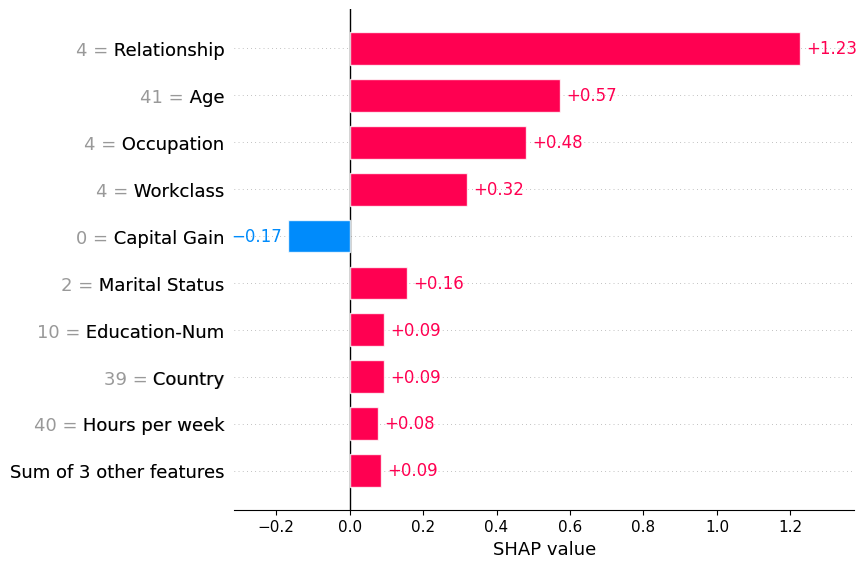

SHAP values for closest flipped instance 2 (index 594):


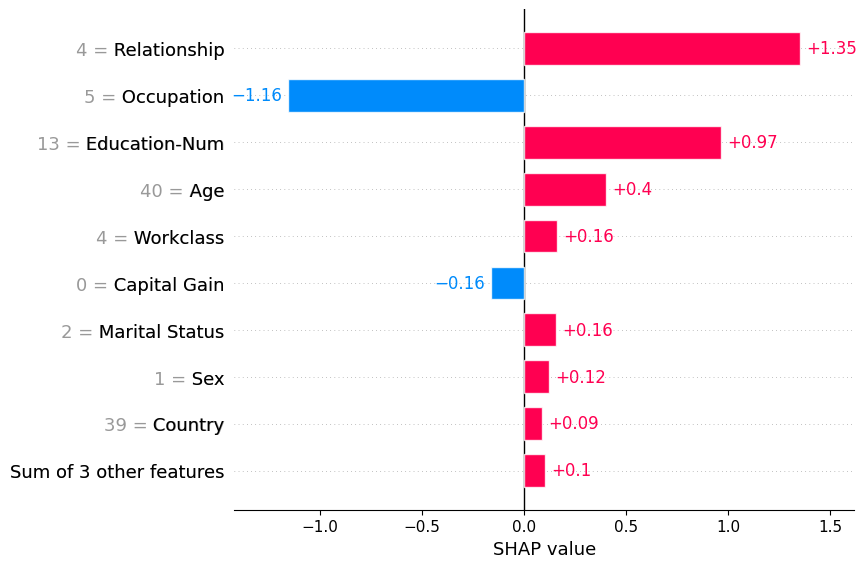

SHAP values for closest flipped instance 3 (index 633):


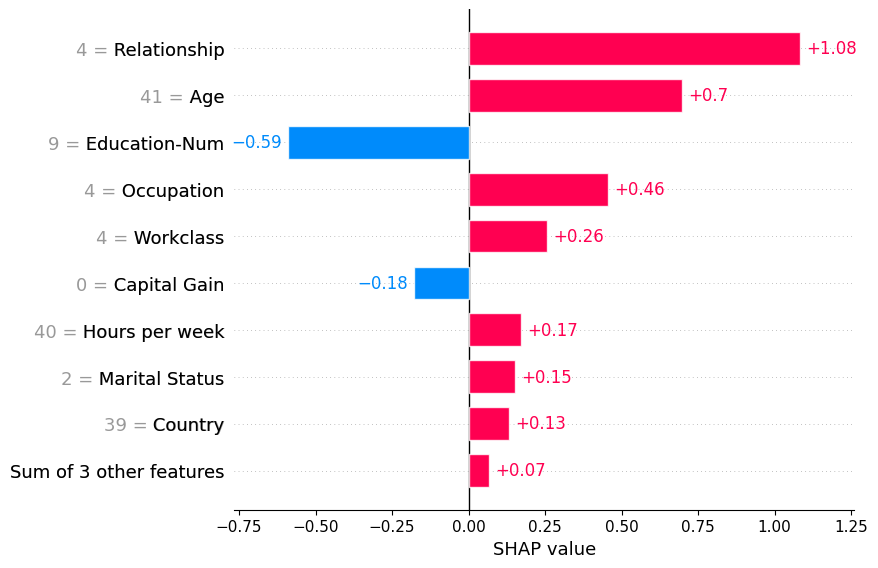

SHAP values for closest flipped instance 4 (index 996):


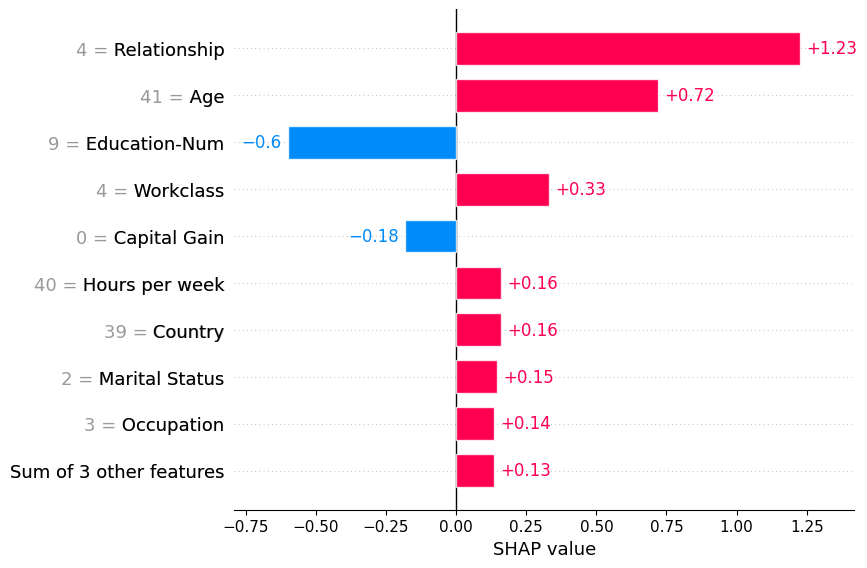

SHAP values for closest flipped instance 5 (index 1304):


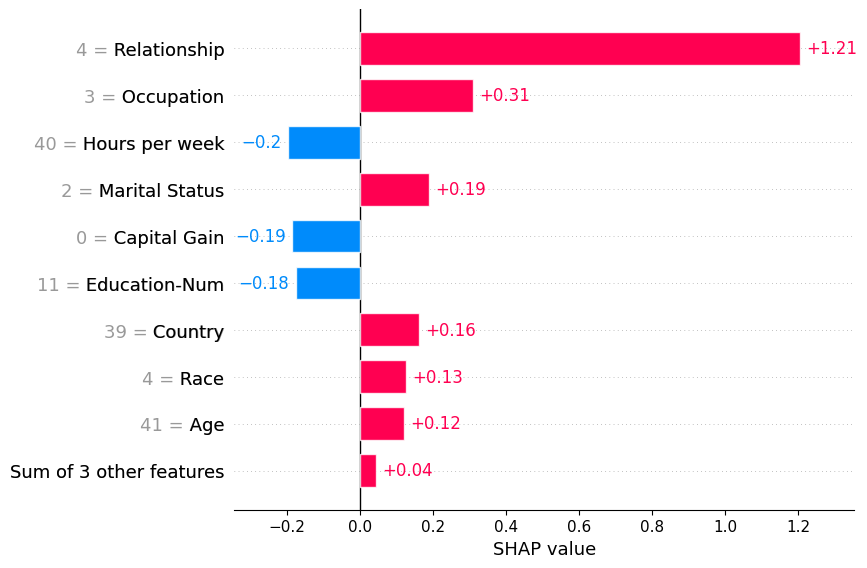

SHAP values for closest flipped instance 6 (index 143):


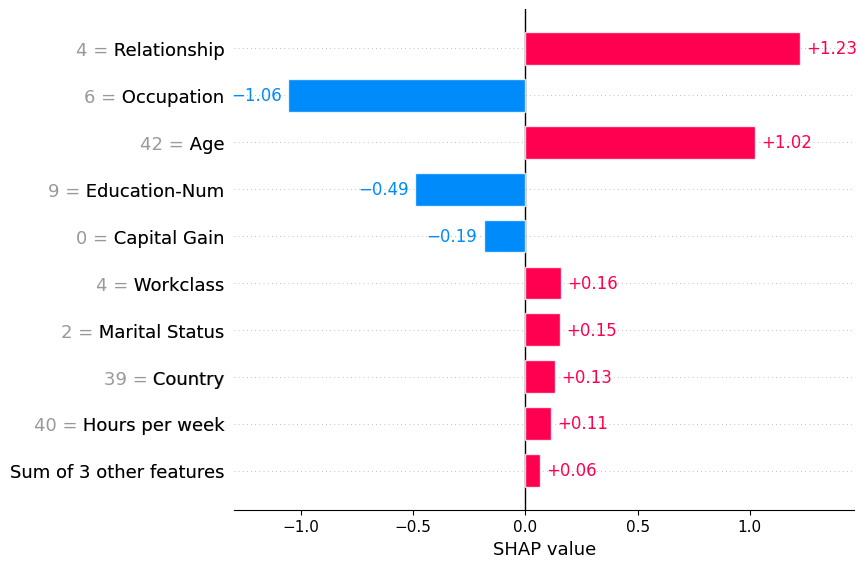

SHAP values for closest flipped instance 7 (index 887):


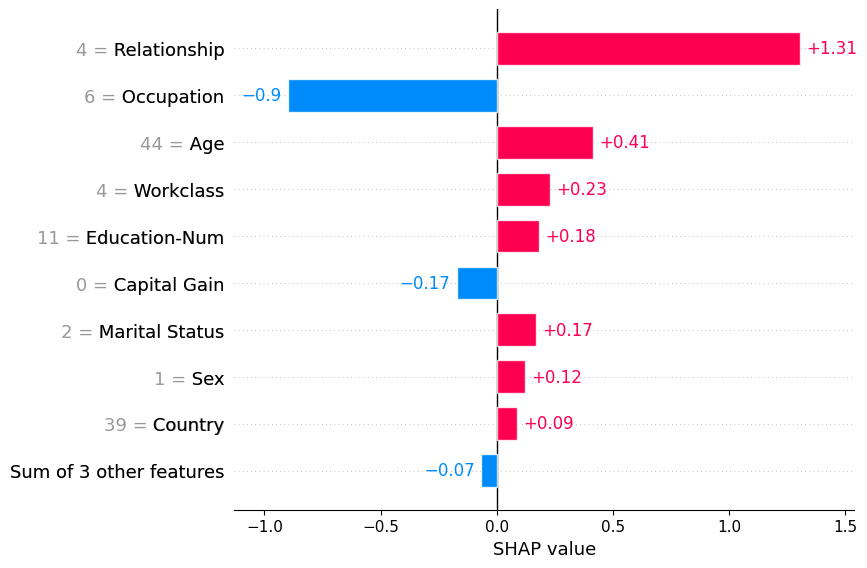

SHAP values for closest flipped instance 8 (index 1519):


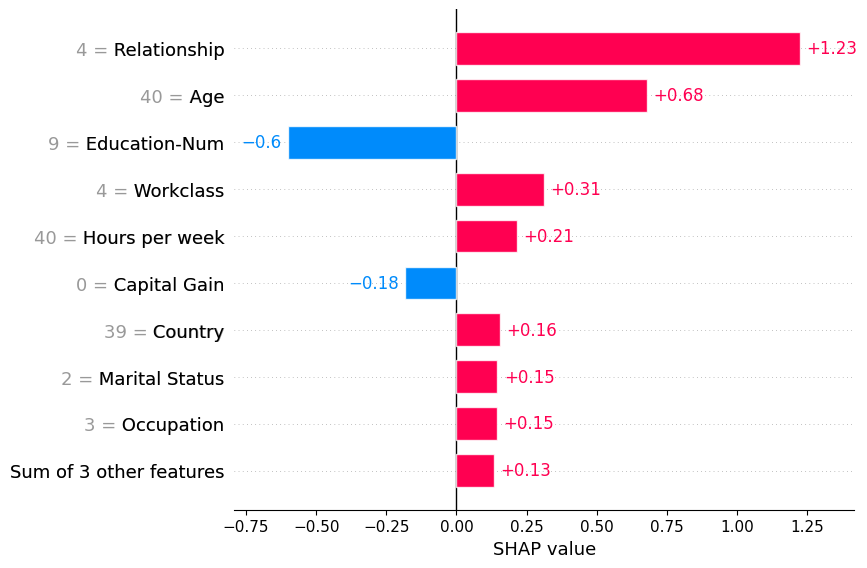

SHAP values for closest flipped instance 9 (index 1599):


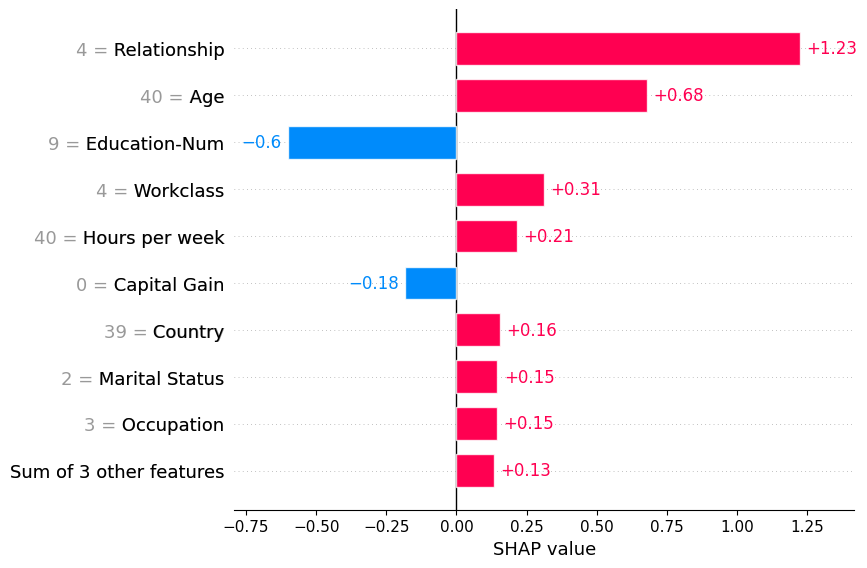

SHAP values for closest flipped instance 10 (index 267):


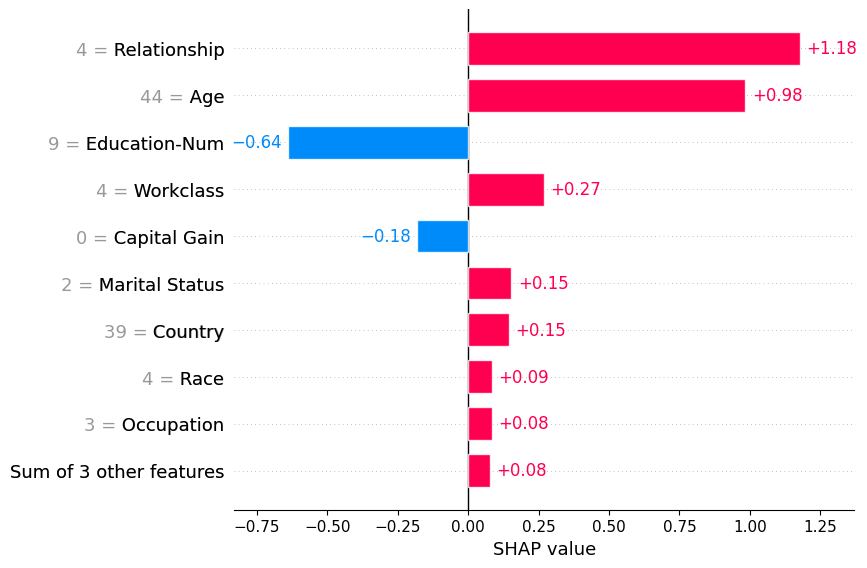

In [132]:
import xgboost
import shap
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

# Load the dataset
X, y = shap.datasets.adult(n_points=2000)
model = xgboost.XGBClassifier().fit(X, y)

# Convert y to binary high-income and low-income
y_binary = np.array([1 if income == True else 0 for income in y])

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
current_instance = X.iloc[100]  # Example: current instance
current_shap_values = shap_values[100]

# Predict the initial outcome
initial_prediction = model.predict(current_instance.values.reshape(1, -1))[0]
initial_probability = model.predict_proba(current_instance.values.reshape(1, -1))[0, 1]
print(f"Initial prediction: {initial_prediction}, Initial probability: {initial_probability}")

# Calculate Euclidean distances between the current instance and all other instances
distances = cdist(X, current_instance.values.reshape(1, -1), metric='euclidean').flatten()

# Predict outcomes for all instances
predictions = model.predict(X)

# Filter instances with a different predicted outcome
flipped_indices = [i for i in range(len(predictions)) if (predictions[i] != initial_prediction and predictions[i]==y_binary[i])]

# Sort the flipped instances by distance
sorted_flipped_indices = sorted(flipped_indices, key=lambda i: distances[i])

# Get the indices of the 10 closest flipped instances
closest_flipped_indices = sorted_flipped_indices[:10]

# Retrieve the closest flipped instances
closest_flipped_instances = X.iloc[closest_flipped_indices]

# Print the closest flipped instances and their predictions
for idx in closest_flipped_indices:
    instance = X.iloc[idx]
    prediction = model.predict(instance.values.reshape(1, -1))[0]
    probability = model.predict_proba(instance.values.reshape(1, -1))[0, 1]
    print(f"Instance {idx}: Prediction: {prediction}, Probability: {probability}")
    print(instance)
    print()

# Compute SHAP values for the closest flipped instances
closest_flipped_shap_values = explainer(closest_flipped_instances)

# Visualize SHAP values for the closest flipped instances
for i in range(len(closest_flipped_indices)):
    print(f"SHAP values for closest flipped instance {i+1} (index {closest_flipped_indices[i]}):")
    shap.plots.bar(closest_flipped_shap_values[i])


In [123]:
shap_values[100]

.values =
array([ 0.93022247,  0.35009296,  0.21841757,  0.15534689,  0.72388488,
        1.16562014,  0.07024311,  0.10113488, -0.1643196 , -0.0173873 ,
        0.14908155,  0.09210933])

.base_values =
-3.034144449280776

.data =
array([42.,  4., 12.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.])

In [122]:
shap_values[633]

.values =
array([ 0.69694448,  0.2566758 , -0.58991922,  0.1523479 ,  0.45601609,
        1.08432168,  0.05423153,  0.03567061, -0.17790174, -0.02362666,
        0.17064072,  0.13206133])

.base_values =
-3.034144449280776

.data =
array([41.,  4.,  9.,  2.,  4.,  4.,  4.,  1.,  0.,  0., 40., 39.])